# Analyze data from flowmeter test

In [182]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Claim: The 'internal' and 'external' flow meter are measuring the same flow rate.

H0: The internal flow meter is measuring the same flow as the external flow meter.
H1: The internal flow meter is measuring a lower flow.  
  
Significance: 0.01 (1%)  
  
After conducting a two samples t test the null hypothesis is rejected for set_pump_duty_cycle  100, 250, 400, 550 & 700 and not for 850.  
  
The best estimate of the relative difference for these set_pump_duty_cycles is:  
-0.015398, -0.021594, -0.020679, -0.010922 &  0.009224

The average flowrate for set_pump_duty_cycle 400 or higher < 600 l/hr, so is not very relevant in practice. So, we should change increase our measurements with 1.6% - 2.2% to get a more realistic flowrate.

In [185]:
results_total = pd.DataFrame(columns=['test_number', 'time', 'set_pump_duty_cycle', 'get_pump_duty_cycle', 'internal_flow', 'external_flow'])
i = 1


# loop through files in flow_meter_test_data folder
for file in os.listdir('./flow_meter_test_data/data'):
    # read csv file
    df = pd.read_csv('./flow_meter_test_data/data/' + file)
    df['test_number'] = f'flow_meter_{i}'
    
    # add file to results dataframe
    results_total = pd.concat([results_total,df], ignore_index=True)
    i += 1

# filter out last 24 measurements of each flow rate (because the first 1 minute is needed to reach a steady state)
results_filtered = results_total.groupby(['test_number', 'set_pump_duty_cycle']).tail(24)

# results_means = results_filtered.groupby(['test_number', 'set_pump_duty_cycle']).mean().reset_index(drop=True)
# results_means['flowmeter_difference'] = results_means['internal_flow'] - results_means['external_flow']
# results_means['flowmeter_external_average'] = results_means.groupby('set_pump_duty_cycle').apply(lambda x: x['external_flow'].mean()).reset_index(drop=True)
# results_means['flowmeter_difference_relative'] = results_means['flowmeter_difference'] / results_means['flowmeter_external_average']
# results_std = results_filtered.groupby(['test_number', 'set_pump_duty_cycle']).std().reset_index()

In [189]:
# null hypothesis: flowmeter internal mean is flowmeter external mean
# alternative hypothesis: flowmeter internal mean is not equal to flowmeter external mean
# significance level: 0.05
# if p-value < 0.05, reject null hypothesis
# if p-value > 0.05, fail to reject null hypothesis
# p-values are calculated using a two-sided t-test
results_p_values = results_filtered.groupby(['set_pump_duty_cycle']).apply(lambda x: stats.ttest_ind(x['internal_flow'], x['external_flow'])[1]).reset_index()
print(results_p_values)

   set_pump_duty_cycle              0
0                  100  1.613637e-107
1                  250  5.254502e-129
2                  400  2.304203e-107
3                  550   3.801207e-46
4                  700   3.733409e-26
5                  850   3.431528e-02


In [192]:
# check when external meter changes
results_filtered['external_flow_change'] = results_filtered['external_flow'].diff()

# Calculate degrees of freedom
n_internal = (results_filtered.groupby(['set_pump_duty_cycle']).count()['internal_flow']).reset_index(drop=True)
n_external = (results_filtered[results_filtered['external_flow_change'].abs()>0].groupby(['set_pump_duty_cycle']).count()['external_flow']).reset_index(drop=True)
degrees_of_freedom = n_internal + n_external - 2
print(n_internal, n_external, degrees_of_freedom)

0    264
1    264
2    264
3    264
4    264
5    264
Name: internal_flow, dtype: int64 0    31
1    32
2    33
3    31
4    29
5    27
Name: external_flow, dtype: int64 0    293
1    294
2    295
3    293
4    291
5    289
dtype: int64


/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_94402/2179083340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_filtered['external_flow_change'] = results_filtered['external_flow'].diff()


In [194]:
# t value from table for 95% confidence interval for 289 degrees of freedom is 1.968
# t value from table for 99% confidence interval for 289 degrees of freedom is 2.3263

# calculate t value
sum_of_squares_internal = (results_filtered.groupby(['set_pump_duty_cycle']).std()['internal_flow']).reset_index(drop=True)**2 * (n_internal-1)
sum_of_squares_external = (results_filtered[results_filtered['external_flow_change'].abs()>0].groupby(['set_pump_duty_cycle']).std()['external_flow']).reset_index(drop=True)**2 * (n_external-1)

# calculate pooled variance
pooled_variance = (sum_of_squares_internal + sum_of_squares_external) / degrees_of_freedom

# calculate t value
sample_mean_internal = (results_filtered.groupby(['set_pump_duty_cycle']).mean()['internal_flow']).reset_index(drop=True)
sample_mean_external = (results_filtered[results_filtered['external_flow_change'].abs()>0].groupby(['set_pump_duty_cycle']).mean()['external_flow']).reset_index(drop=True)
t_values = (sample_mean_internal - sample_mean_external) / np.sqrt(pooled_variance * (1/n_internal + 1/n_external))

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_94402/3086961772.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_of_squares_internal = (results_filtered.groupby(['set_pump_duty_cycle']).std()['internal_flow']).reset_index(drop=True)**2 * (n_internal-1)
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_94402/3086961772.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_of_squares_external = (results_filtered[results_filtered['external_flow_change'].abs()>0].groupby(['set_pump_duty_cycle']).std()['external_flow']).reset_index(drop=True)**2 * (n_external-1)
/var/folders/0m/6_0b79

In [197]:
t_values_95 = 1.968 * np.sqrt(pooled_variance * (1/n_internal + 1/n_external))
t_values_99 = 2.3263 * np.sqrt(pooled_variance * (1/n_internal + 1/n_external))

p_values = stats.t.sf(np.abs(t_values), degrees_of_freedom)*2
print(p_values)
print(t_values)
print(t_values_95)
print(t_values_99)

[4.34717418e-22 1.54834861e-28 1.23859290e-23 3.63495396e-08
 4.33650998e-06 4.84255057e-01]
0   -10.496158
1   -12.357901
2   -10.947497
3    -5.658444
4     4.683309
5     0.700377
dtype: float64
0    3.273973
1    2.986469
2    2.060706
3    1.539469
4    1.202794
5    9.162939
dtype: float64
0     3.870042
1     3.530194
2     2.435884
3     1.819749
4     1.421779
5    10.831172
dtype: float64


In [201]:
# this means that we can reject the null hypothesis for set_pump_duty_cycle 100, 250, 400, 550 & 700
# Then the differences between the flow meters is significant for these pump duty cycles
# our best guess at estimating this difference is by comparing the means of the internal and external flow meters
# the difference between the means is the best estimate of the difference between the flow meters
# the standard deviation of the difference between the means is the best estimate of the standard deviation of the difference between the flow meters

# calculate mean difference between internal and external flow meters
mean_difference = sample_mean_internal - sample_mean_external
print(mean_difference)

# calculate relative difference between internal and external flow meters
mean_difference_relative = mean_difference / sample_mean_internal
print(mean_difference_relative)
print(external_means)


0   -17.461451
1   -18.753295
2   -11.463198
3    -4.426320
4     2.862326
5     3.260933
dtype: float64
0   -0.015638
1   -0.022071
2   -0.021116
3   -0.011043
4    0.009140
5    0.014718
dtype: float64
set_pump_duty_cycle
100    1127.875000
250     862.833333
400     557.833333
550     404.000000
700     310.166667
850     218.291667
Name: external_flow, dtype: float64


In [121]:
print(results_means.groupby(['set_pump_duty_cycle']).apply(lambda x: stats.ttest_ind(x['internal_flow'], x['external_flow'])))

set_pump_duty_cycle
100    (-6.739207725053396, 1.4801416894470762e-06)
250     (-7.616841190882206, 2.467090018753073e-07)
400      (-7.190427007416208, 5.81606118414656e-07)
550     (-4.381190066337087, 0.0002886135075163516)
700      (3.805446892939028, 0.0011083472705890598)
850         (1.5819982574821603, 0.129335853103381)
dtype: object


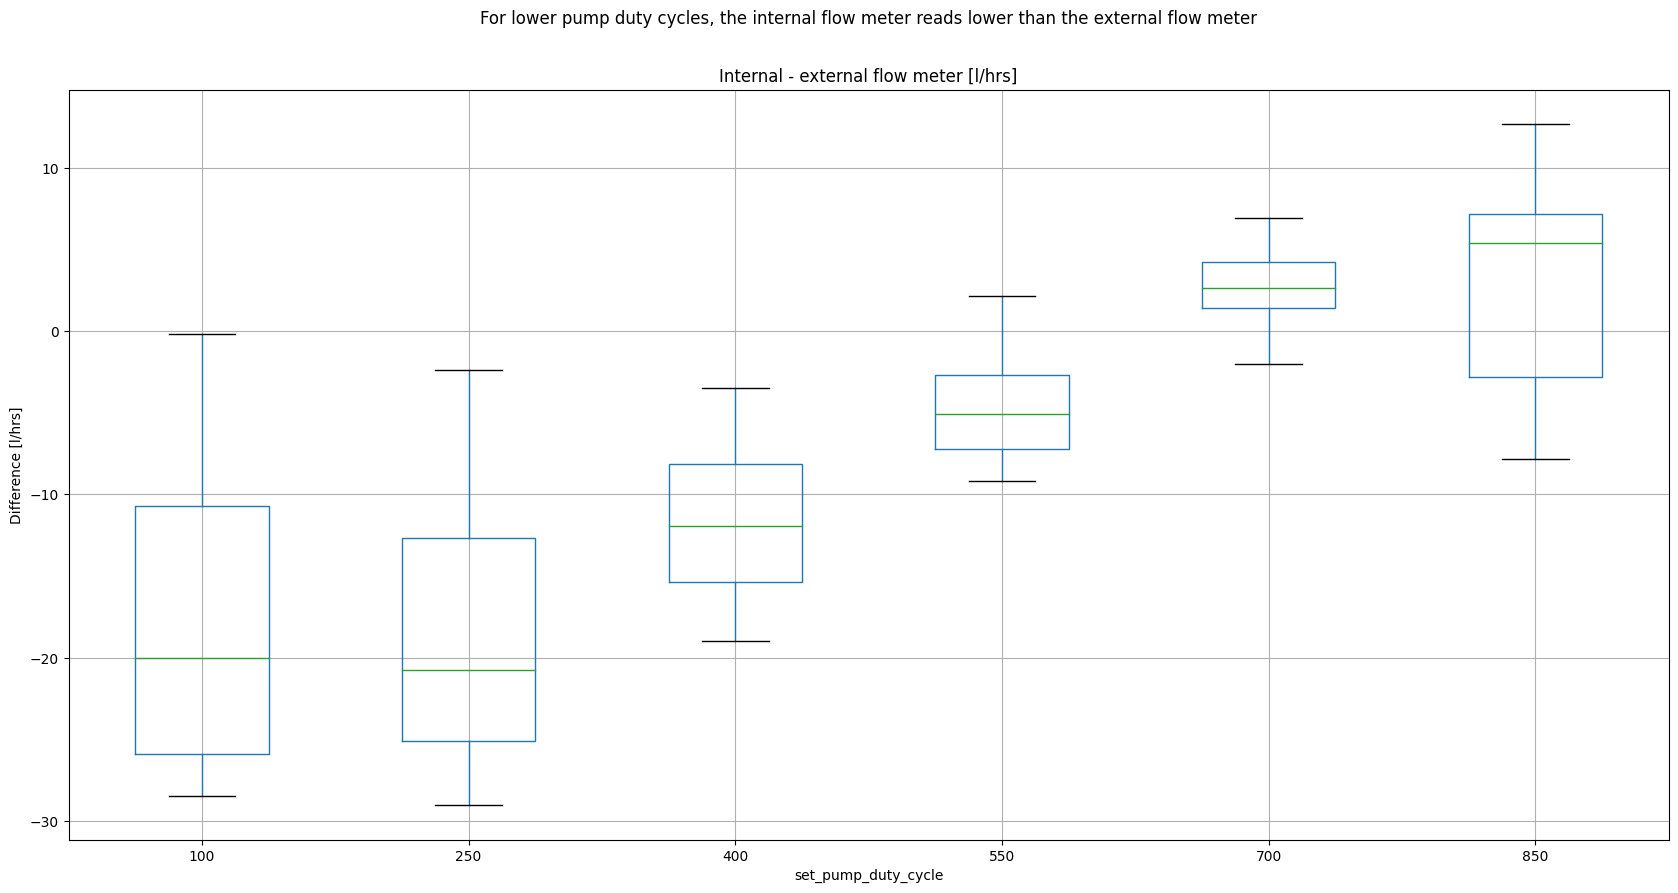

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_94402/218344058.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_filtered['flowmeter_difference'] = results_filtered['internal_flow'] - results_filtered['external_flow']


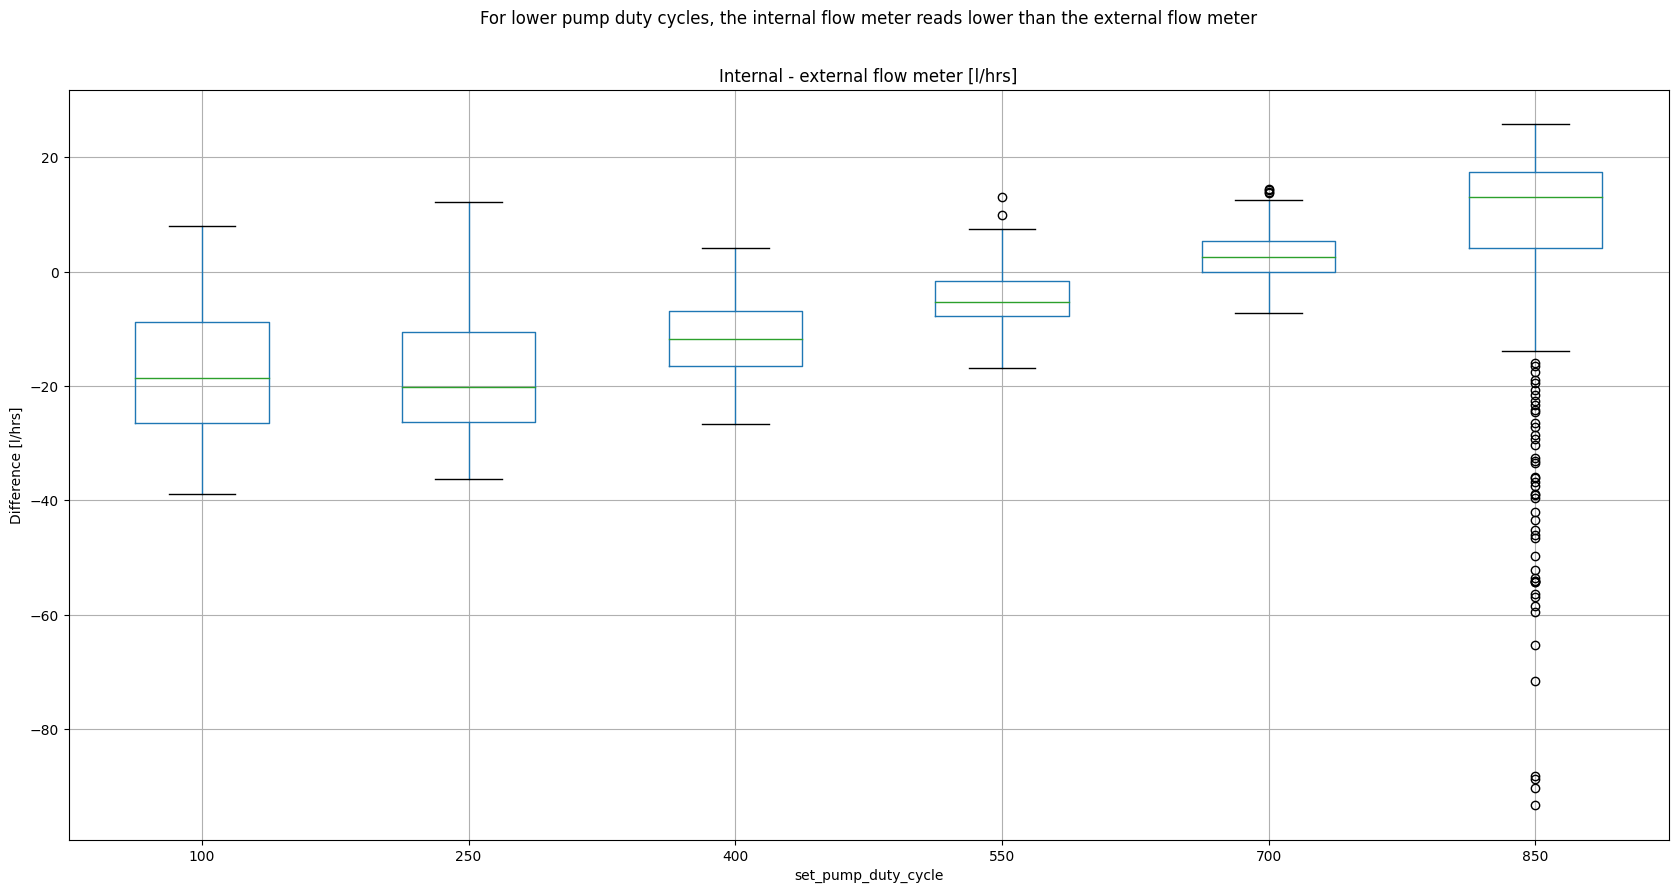

In [126]:
results_means.boxplot(by='set_pump_duty_cycle', column=['flowmeter_difference'], figsize=(20,10))
plt.title('Internal - external flow meter [l/hrs]')
plt.suptitle('For lower pump duty cycles, the internal flow meter reads lower than the external flow meter')
plt.ylabel('Difference [l/hrs]')
plt.show()
results_filtered['flowmeter_difference'] = results_filtered['internal_flow'] - results_filtered['external_flow']
results_filtered.boxplot(by='set_pump_duty_cycle', column=['flowmeter_difference'], figsize=(20,10))
plt.title('Internal - external flow meter [l/hrs]')
plt.suptitle('For lower pump duty cycles, the internal flow meter reads lower than the external flow meter')
plt.ylabel('Difference [l/hrs]')
plt.show()


Ttest_indResult(statistic=-0.41400683575618086, pvalue=0.6789205644628025)
TtestResult(statistic=-13.25585225408103, pvalue=1.2223791175324314e-36, df=863)


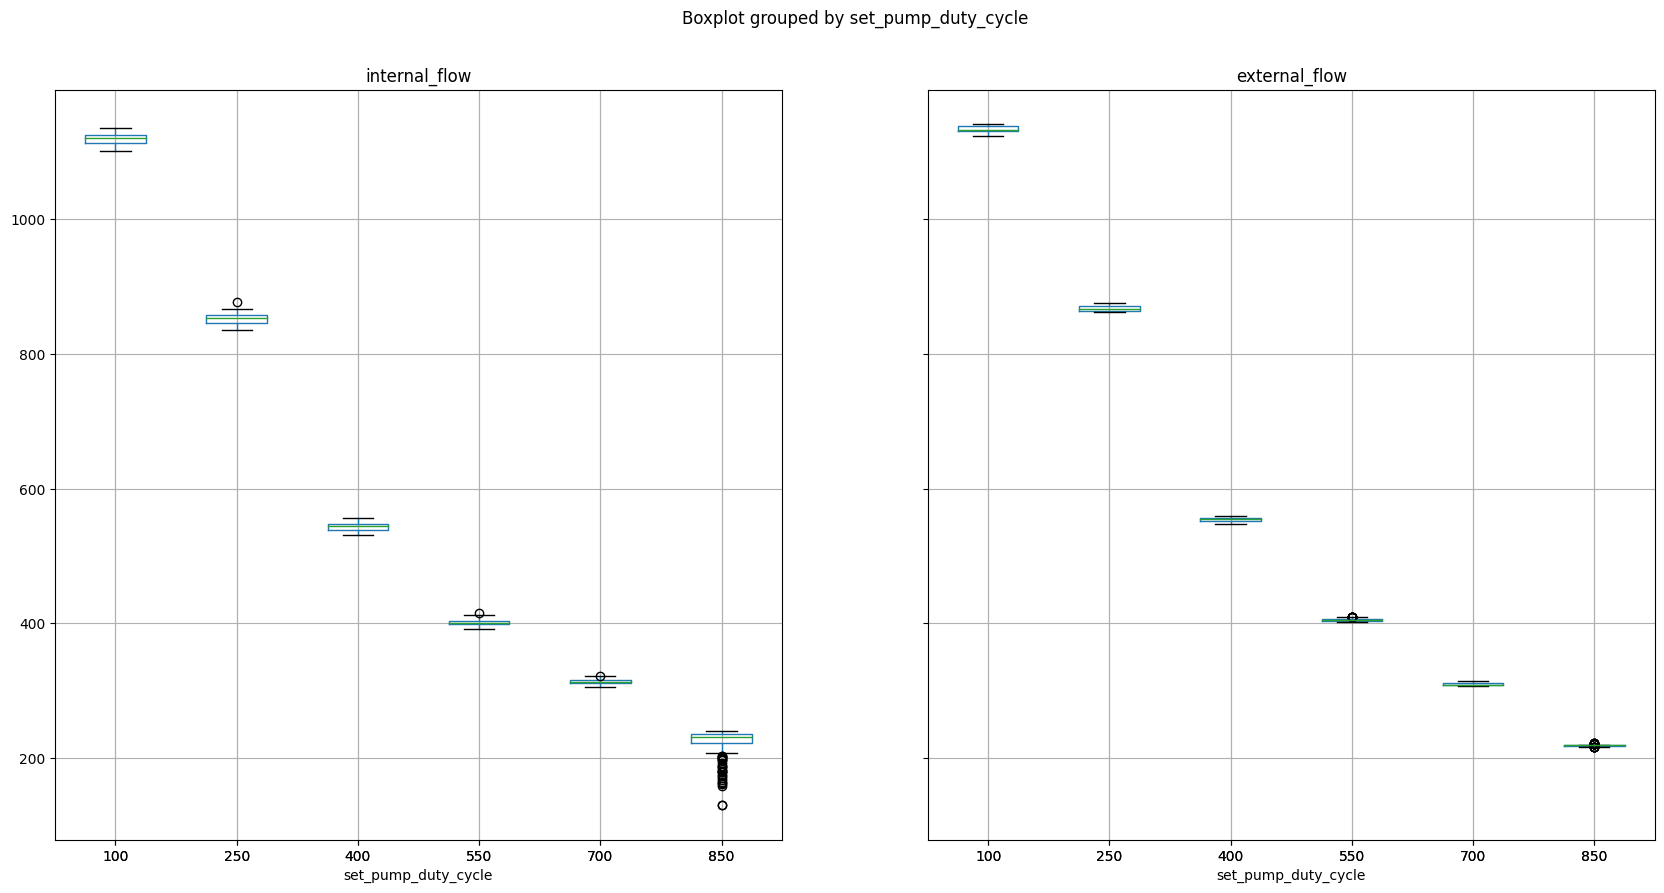

In [112]:
results_total
temporary_df = results_total.groupby(['test_number', 'set_pump_duty_cycle']).tail(24)
print(stats.ttest_ind(temporary_df['internal_flow'], temporary_df['external_flow'], equal_var=False))
print(stats.ttest_rel(temporary_df['internal_flow'], temporary_df['external_flow']))
temporary_df.boxplot(by='set_pump_duty_cycle', column=['internal_flow', 'external_flow'], figsize=(20,10))
plt.show()


In [115]:
temporary_df.groupby(['test_number', 'set_pump_duty_cycle']).agg('mean','std')

time  get_pump_duty_cycle  \
test_number  set_pump_duty_cycle                                      
flow_meter_1 100                  1.685706e+09            49.000000   
             250                  1.685706e+09            35.791667   
             400                  1.685706e+09            22.000000   
             550                  1.685706e+09            14.000000   
             700                  1.685707e+09             9.083333   
             850                  1.685707e+09             8.000000   
flow_meter_2 100                  1.685701e+09            48.958333   
             250                  1.685701e+09            35.958333   
             400                  1.685701e+09            22.000000   
             550                  1.685701e+09            14.000000   
             700                  1.685702e+09             9.083333   
             850                  1.685702e+09             8.000000   
flow_meter_3 100                  1.685707e+09            48.958333   
             250                  1.685707e+09            35.958333   
             400                  1.685707e+09            22.000000   
             550                  1.685708e+09            14.000000   
             700                  1.685708e+09             9.125000   
             850                  1.685708e+09             8.000000   
flow_meter_4 100                  1.685705e+09            49.000000   
             250                  1.685705e+09            35.916667   
             400                  1.685705e+09            22.000000   
             550                  1.685705e+09            14.000000   
             700                  1.685705e+09             9.000000   
             850                  1.685705e+09             8.000000   
flow_meter_5 100                  1.685699e+09            48.958333   
             250                  1.685700e+09            35.958333   
             400                  1.685700e+09            22.000000   
             550                  1.685700e+09            14.000000   
             700                  1.685700e+09             9.291667   
             850                  1.685700e+09             8.000000   
flow_meter_6 100                  1.685697e+09            48.875000   
             250                  1.685697e+09            35.416667   
             400                  1.685698e+09            22.000000   
             550                  1.685698e+09            13.958333   
             700                  1.685698e+09             9.416667   
             850                  1.685698e+09             8.000000   

                                  internal_flow  external_flow  
test_number  set_pump_duty_cycle                                
flow_meter_1 100                    1121.423985    1135.000000  
             250                     853.222516     868.750000  
             400                     546.281991     550.833333  
             550                     401.579707     404.375000  
             700                     313.485830     309.375000  
             850                     223.822393     218.500000  
flow_meter_2 100                    1108.557004    1137.041667  
             250                     842.966206     869.750000  
             400                     538.659028     552.500000  
             550                     397.607140     406.791667  
             700                     312.369236     309.708333  
             850                     213.016975     220.833333  
flow_meter_3 100                    1124.302884    1134.750000  
             250                     858.130014     868.541667  
             400                     547.452512     554.416667  
             550                     403.654613     405.333333  
             700                     313.799958     308.833333  
             850                     226.773223     218.625000  
flow_meter_4 100                    1112.74

,id,time,set_pump_duty_cycle,get_pump_duty_cycle,internal_flow,external_flow,test_number
0,NaN,1.685706e+09,100,0.0,0.000000,0.0,flow_meter_1
1,NaN,1.685706e+09,100,36.0,83.880676,0.0,flow_meter_1
2,NaN,1.685706e+09,100,31.0,804.379093,0.0,flow_meter_1
3,NaN,1.685706e+09,100,49.0,1094.632696,0.0,flow_meter_1
4,NaN,1.685706e+09,100,48.0,1124.132459,0.0,flow_meter_1
...,...,...,...,...,...,...,...
1291,NaN,1.685698e+09,850,8.0,236.078908,217.0,flow_meter_6
1292,NaN,1.685698e+09,850,8.0,162.648843,217.0,flow_meter_6
1293,NaN,1.685698e+09,850,8.0,232.757064,217.0,flow_meter_6
1294,NaN,1.685698e+09,850,8.0,207.289063,217.0,flow_meter_6


<Axes: xlabel='set_pump_duty_cycle'>

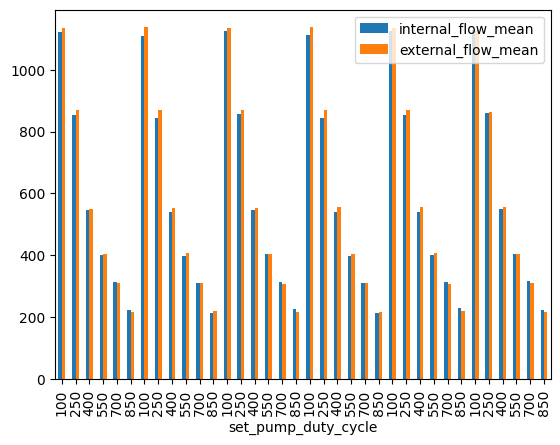

In [89]:
results_mean.plot(x='set_pump_duty_cycle', y=['internal_flow_mean', 'external_flow_mean'], kind='bar')

In [ ]:
   

results['flow_difference'] = results['internal_flow'] - results['external_flow']

results['get_pump_duty_cycle_diff'] = results['get_pump_duty_cycle'].diff()

results['internal_flow_mean'] = results.groupby(['test_number','set_pump_duty_cycle'],sort='time')[4:]['internal_flow'].mean()
results['external_flow_mean'] = results.groupby(['test_number','set_pump_duty_cycle'],sort='time')[13:]['external_flow'].mean()

# plot results


df1 = pd.read_csv('./flow_meter_test_data/flow_meter_test_1685626411.csv')
df2 = pd.read_csv('./flow_meter_test_data/flow_meter_test_1685630641.csv')

In [27]:
# find lag between set_pump_duty_cycle and get_pump_duty_cycle
df2['set_pump_duty_cycle_diff'] = df2['set_pump_duty_cycle'].diff()
df2['get_pump_duty_cycle_diff'] = df2['get_pump_duty_cycle'].diff()
lag_pump_duty_cycle = np.mean(df2[df2['set_pump_duty_cycle_diff'] != 0]['time'] - df2[df2['set_pump_duty_cycle_diff'] != 0]['time'])
print('Lag between set and get of pump duty cycle: ', lag_pump_duty_cycle)

# get only rows where get_pump_duty_cycle_diff=0 (i.e pump has reached a steady state)

# filter out rows where external_flow diff > 0 if this is too close to rows where get_pump_duty_cycle_diff!=0
df2['external_flow_diff'] = df2['external_flow'].diff()

# find rows where external_flow_diff != 0 and how recently the get_pump _duty_cycle was changed




0.0


In [76]:
test = pd.read_csv('./flow_meter_test_data/flow_meter_test_1685698113.csv')
test['get_pump_duty_cycle_diff'] = test['get_pump_duty_cycle'].diff()
# test['internal_flow_mean'] = test.groupby(['set_pump_duty_cycle'],sort='time')[4:]['internal_flow'].mean()
external_means = test.groupby(['set_pump_duty_cycle'])['external_flow'].apply(lambda x: x.tail(24).mean())
internal_means = test.groupby(['set_pump_duty_cycle'])['internal_flow'].apply(lambda x: x.tail(24).mean())


In [78]:
results_test.append(pd.DataFrame({'set_pump_duty_cycle': external_means.index, 'external_flow_mean': external_means.values, 'internal_flow_mean': internal_means.values,'id':1}), ignore_index=True)

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_94402/2244787742.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_test.append(pd.DataFrame({'set_pump_duty_cycle': external_means.index, 'external_flow_mean': external_means.values, 'internal_flow_mean': internal_means.values,'id':1}), ignore_index=True)


,id,flowrate,average_interal,average_external,set_pump_duty_cycle,external_flow_mean,internal_flow_mean
0,1,NaN,NaN,NaN,100.0,1127.875000,1127.684501
1,1,NaN,NaN,NaN,250.0,862.833333,860.443953
2,1,NaN,NaN,NaN,400.0,557.833333,548.536333
3,1,NaN,NaN,NaN,550.0,404.000000,406.120630
4,1,NaN,NaN,NaN,700.0,310.166667,317.073389
5,1,NaN,NaN,NaN,850.0,218.291667,223.663158


In [67]:
results_test = pd.DataFrame(columns=['id','flowrate','average_interal','average_external'])

In [63]:
test[test['set_pump_duty_cycle']==850]

,time,set_pump_duty_cycle,get_pump_duty_cycle,internal_flow,external_flow,get_pump_duty_cycle_diff,external_flow_mean
180,1.685698e+09,850,9.0,314.356947,314.0,-1.0,NaN
181,1.685698e+09,850,8.0,187.122308,314.0,-1.0,NaN
182,1.685698e+09,850,8.0,236.693246,314.0,0.0,NaN
183,1.685698e+09,850,8.0,233.867495,314.0,0.0,NaN
184,1.685698e+09,850,8.0,163.933785,314.0,0.0,NaN
185,1.685698e+09,850,8.0,233.509260,218.0,0.0,NaN
186,1.685698e+09,850,8.0,233.594625,218.0,0.0,NaN
187,1.685698e+09,850,8.0,229.593916,218.0,0.0,NaN
188,1.685698e+09,850,8.0,235.614546,218.0,0.0,NaN
189,1.685698e+09,850,8.0,234.316454,218.0,0.0,NaN
